# Segmentation

This notebook is for segmenting timelapse microscopy data, with associated sinhgle-cell labels and tracks, showing the infection of human macrophages with Mycobacterium Tuberculosis (Mtb), acquired on an Opera Phenix confocal microscope. 

In [1]:
import napari
import cellpose
from octopuslite import utils, tile

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

# Creating a separate 8bit folder for speed tests

In [9]:
row = '6'
column = '9'

In [ ]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'


In [82]:
from tqdm.auto import tqdm
import glob, os, cv2
from skimage.io import imread, imsave
import napari

In [30]:
def view(img):
    return napari.Viewer().add_image(img)

In [35]:
_8bit_images_fns = glob.glob(os.path.join(image_dir, f'r0{row}c0{column}f0*p0*-ch*sk*fk1fl1.tiff'))
_8bit_images_fns = [fn for fn in _8bit_images_fns if 'ch99' not in fn]

In [68]:
gfp_img = None
rfp_img = None

In [107]:
def map_uint16_to_uint8(img, lower_bound=0, upper_bound=65535):
    '''
    Map a 16-bit image trough a lookup table to convert it to 8-bit.

    Parameters
    ----------
    img: numpy.ndarray[np.uint16]
        image that should be mapped
    lower_bound: int, optional
        lower bound of the range that should be mapped to ``[0, 255]``,
        value must be in the range ``[0, 65535]`` and smaller than `upper_bound`
        (defaults to ``numpy.min(img)``)
    upper_bound: int, optional
       upper bound of the range that should be mapped to ``[0, 255]``,
       value must be in the range ``[0, 65535]`` and larger than `lower_bound`
       (defaults to ``numpy.max(img)``)

    Returns
    -------
    numpy.ndarray[uint8]
    '''
    if not(0 <= lower_bound < 2**16) and lower_bound is not None:
        raise ValueError(
            '"lower_bound" must be in the range [0, 65535]')
    if not(0 <= upper_bound < 2**16) and upper_bound is not None:
        raise ValueError(
            '"upper_bound" must be in the range [0, 65535]')
    if lower_bound is None:
        lower_bound = np.min(img)
    if upper_bound is None:
        upper_bound = np.max(img)
    if lower_bound >= upper_bound:
        raise ValueError(
            '"lower_bound" must be smaller than "upper_bound"')
    lut = np.concatenate([
        np.zeros(lower_bound, dtype=np.uint16),
        np.linspace(0, 255, upper_bound - lower_bound).astype(np.uint16),
        np.ones(2**16 - upper_bound, dtype=np.uint16) * 255
    ])
    return lut[img].astype(np.uint8)


# Convert it to 8-bit
_8bit_img = map_uint16_to_uint8(gfp_img)

In [102]:
for fn in tqdm(_8bit_images_fns):
#     if 'ch1' in fn:
#         gfp_img = imread(fn)
#     if 'ch2' in fn:
#         rfp_img = imread(fn)
    _8bit_img = (img/256).astype(np.uint8)
    new_fn = fn.replace('Images', 'Images_8bit')
#     imsave(new_fn, _)
    break

  0%|          | 0/4050 [00:00<?, ?it/s]

In [108]:
view(_8bit_img)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'img' at 0x7f89af19c970>

In [54]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [76]:
view(gfp_img)
view(rfp_img)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'img' at 0x7f8a1c3764f0>

In [91]:
gfp_img.dtype

dtype('uint16')

In [96]:
view(imread('/home/dayn/Videos/tb_mp4s/tiling/image_sequence/strain.WT_compound.BDQ_conc.2.5_row.6_column.9/t14_ch1.tiff'))

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'img' at 0x7f8a33376a30>

In [92]:
2**16

65536

(array([1.799994e+06, 7.716600e+05, 5.072210e+05, 4.462130e+05,
        3.284270e+05, 2.477850e+05, 1.818470e+05, 1.276040e+05,
        9.017500e+04, 6.158000e+04, 4.108900e+04, 2.607000e+04,
        1.383100e+04, 8.894000e+03, 5.008000e+03, 3.194000e+03,
        1.971000e+03, 1.358000e+03, 1.298000e+03, 3.810000e+02]),
 array([  87. ,  261.1,  435.2,  609.3,  783.4,  957.5, 1131.6, 1305.7,
        1479.8, 1653.9, 1828. , 2002.1, 2176.2, 2350.3, 2524.4, 2698.5,
        2872.6, 3046.7, 3220.8, 3394.9, 3569. ]),
 <BarContainer object of 20 artists>)

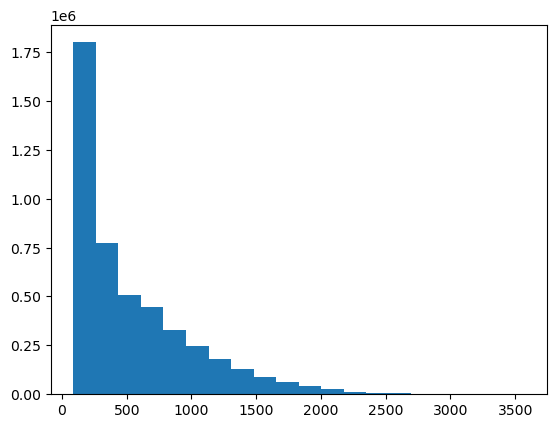

In [86]:
plt.hist(gfp_img.flatten(), bins = 20)

In [93]:
view((gfp_img/65536).astype(np.uint8))

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'img' at 0x7f8a33583910>

(array([1.759434e+06, 1.044000e+06, 0.000000e+00, 6.854590e+05,
        4.669160e+05, 0.000000e+00, 3.037990e+05, 1.838450e+05,
        0.000000e+00, 1.084980e+05, 5.989600e+04, 0.000000e+00,
        2.854800e+04, 1.326300e+04, 0.000000e+00, 6.046000e+03,
        3.067000e+03, 0.000000e+00, 2.027000e+03, 8.020000e+02]),
 array([ 0.  ,  0.65,  1.3 ,  1.95,  2.6 ,  3.25,  3.9 ,  4.55,  5.2 ,
         5.85,  6.5 ,  7.15,  7.8 ,  8.45,  9.1 ,  9.75, 10.4 , 11.05,
        11.7 , 12.35, 13.  ]),
 <BarContainer object of 20 artists>)

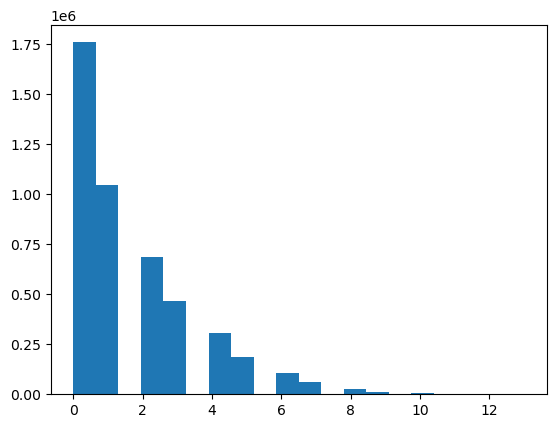

In [89]:
plt.hist(((gfp_img/256).astype(np.uint8)).flatten(), bins = 20)

(array([4.644331e+06, 1.234400e+04, 3.433000e+03, 1.697000e+03,
        1.076000e+03, 7.050000e+02, 4.650000e+02, 3.680000e+02,
        2.960000e+02, 2.460000e+02, 1.720000e+02, 1.540000e+02,
        1.070000e+02, 7.100000e+01, 5.100000e+01, 3.900000e+01,
        1.800000e+01, 6.000000e+00, 1.500000e+01, 6.000000e+00]),
 array([  79. ,  194.9,  310.8,  426.7,  542.6,  658.5,  774.4,  890.3,
        1006.2, 1122.1, 1238. , 1353.9, 1469.8, 1585.7, 1701.6, 1817.5,
        1933.4, 2049.3, 2165.2, 2281.1, 2397. ]),
 <BarContainer object of 20 artists>)

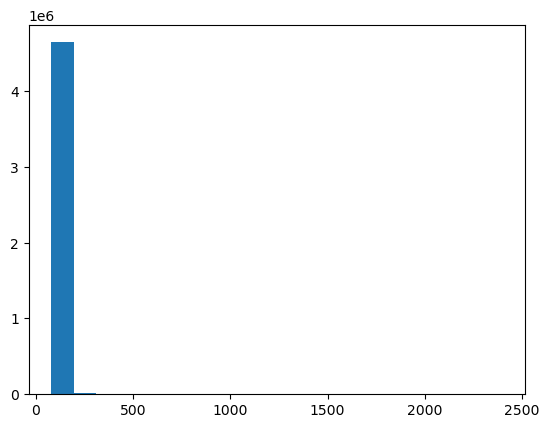

In [85]:
plt.hist(rfp_img.flatten(), bins = 20)

In [44]:
view(other)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'img' at 0x7f8a8cc58730>

In [28]:
other.dtype

dtype('uint16')

In [25]:
img.dtype

dtype('uint8')

In [2]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'
metadata_fn = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Index.idx.xml'
metadata = utils.read_harmony_metadata(metadata_fn)

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


In [10]:
metadata

,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [3]:
metadata_path = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml'
utils.read_harmony_metadata(metadata_path, assay_layout=True)

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

### Define row and column of choice

In [4]:
row = '6'
column = '9'

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [99]:
view(images[0,0,0])

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'img' at 0x7f89aeed2100>

In [110]:
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, 
                             column, 
                             set_channel=1, 
                             set_plane = 'sum_proj',
#                              set_time=1
                            )#.astype(uint8)
images

,Array,Chunk
Bytes,20.44 GiB,31.01 MiB
Shape,"(75, 1, 6048, 6048)","(1, 1, 2016, 2016)"
Count,9450 Tasks,675 Chunks
Type,uint64,numpy.ndarray


# Segment 
Let us start simple, only segmenting the lowest Z plane where the largest regions of cells are and only ch1 (GFP) where the GFP signal is.

In [113]:
!nvcc --version
!nvidia-smi

from cellpose import core, utils, io, models, metrics

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

model = models.Cellpose(gpu=True, model_type='cyto')

def segment(img):
    masks, flows, styles, diams = model.eval(img, diameter=250, channels=[0,0],
                                             flow_threshold=None, cellprob_threshold=0)
    return masks

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Thu Jan 19 12:03:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:65:00.0  On |                  Off |
| 43%   61C    P2    85W / 300W |  27681MiB / 49140MiB |      1%      Default |
|                               |                      |                  N/A |
+

In [114]:
import dask.array as da
from tqdm.auto import tqdm

In [120]:
images

,Array,Chunk
Bytes,20.44 GiB,31.01 MiB
Shape,"(75, 1, 6048, 6048)","(1, 1, 2016, 2016)"
Count,9450 Tasks,675 Chunks
Type,uint64,numpy.ndarray


In [117]:
mask_stack = []
for n, timepoint in tqdm(enumerate(images), total = len(images)):
    ### extract GFP channel and lowest Z plane from single time point
    gfp_z0_frame = timepoint[0,...]
    masks = segment(gfp_z0_frame)
    mask_stack.append(masks)
mask_images = da.stack(mask_stack, axis = 0) 

  0%|          | 0/75 [00:00<?, ?it/s]

In [121]:
%%time
images = images.compute().compute()

CPU times: user 1h 55min 52s, sys: 2min 17s, total: 1h 58min 10s
Wall time: 4min 16s


In [163]:
mask_images_loaded = np.stack(mask_stack, axis = 0)

In [164]:
np.save('masks.npy', mask_images_loaded)

In [151]:
viewer = napari.Viewer()
viewer.add_image(images[:,0,...], colormap = 'green')
viewer.add_labels(mask_images_loaded, name = 'uncleaned')

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'uncleaned' at 0x7f89d67e7f10>

In [126]:
images.shape

(75, 1, 6048, 6048)

# Tidy up segmentation maps

by removing small objects

In [128]:
from skimage.morphology import remove_small_objects, remove_small_holes, binary_erosion

In [145]:
mask_images_loaded_cleaned = mask_images_loaded
for n, mask in tqdm(enumerate(mask_images_loaded), total = 75):
    mask = remove_small_objects(mask, min_size=10000)
    mask_images_loaded_cleaned[n] = mask

  0%|          | 0/75 [00:00<?, ?it/s]

In [137]:
mask.shape

(6048, 6048)

In [147]:
viewer = napari.Viewer()
viewer.add_image(images[:,0,...], colormap = 'green')
viewer.add_labels(mask_images_loaded_cleaned)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'mask_images_loaded_cleaned' at 0x7f8a328deeb0>

In [149]:
viewer = napari.Viewer()
viewer.add_image(images[:,0,...], colormap = 'green')
viewer.add_labels(mask_images_loaded, name = 'UNCLEANED')

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'UNCLEANED' at 0x7f89d6b4f880>

# Finding the size of small masks

In [157]:
from skimage.morphology import label
from skimage.measure import regionprops

In [160]:
regionprops(label((mask_images_loaded == 2).astype(np.uint8)))#[0].area

In [162]:
view((mask_images_loaded == 2).astype(np.uint8))

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'img' at 0x7f89ab838fd0>

In [161]:
view(label((mask_images_loaded == 2).astype(np.uint8)))

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'img' at 0x7f8a19d97fa0>

In [ ]:
mask

In [118]:
import sys
sys.path.append('../macrohet/')
from notify import send_sms

In [119]:
send_sms('max_proj_seg done')